In [1]:
pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import LabelEncoder
from scipy.stats import multivariate_normal


## 1. Import VNINDEX data

In [2]:
data_origin = pd.read_csv("D:\\world quant training\\capstone project\\test\\VNINDEX test.csv")
data_origin

,Ticker,TradingDate,Close,Highest,Lowest,Open,Total Trading Value (billion VND),Total Trading Volume (shares)
0,VNINDEX,1/5/2004,169.16,169.16,167.69,167.69,3.78,"200,210"
1,VNINDEX,1/6/2004,170.26,170.78,170.26,170.78,3.83,"206,380"
2,VNINDEX,1/7/2004,171.17,171.17,170.84,170.84,2.03,"107,740"
3,VNINDEX,1/8/2004,171.60,171.79,171.6,171.79,3.82,"211,360"
4,VNINDEX,1/9/2004,173.27,173.27,171.44,171.44,2.09,"121,590"
...,...,...,...,...,...,...,...,...
4960,VNINDEX,12/7/2023,1121.49,"1,129.83","1,109.51","1,128.67","27,401.24","1,257,964,475"
4961,VNINDEX,12/8/2023,1124.44,"1,127.46","1,119.43","1,122.09","17,714.44","771,456,287"
4962,VNINDEX,12/11/2023,1125.50,"1,129.15","1,120.32","1,127.92","14,630.63","652,376,929"
4963,VNINDEX,12/12/2023,1127.63,"1,129.77","1,123.35","1,127.55","13,951.66","604,857,077"


This code is to select the time range to apply Directional Change (DC) indicator. In this case, I apply to the whole available timeframe. You can change a different timeframe.

In [3]:
# Convert 'TradingDate' to datetime format
data_origin['TradingDate'] = pd.to_datetime(data_origin['TradingDate'])

# Filter rows based on the date range
start_date = '2004-01-05'
end_date = '2023-12-13'
df = data_origin[(data_origin['TradingDate'] >= start_date) & (data_origin['TradingDate'] <= end_date)]

# Display the filtered DataFrame
df


,Ticker,TradingDate,Close,Highest,Lowest,Open,Total Trading Value (billion VND),Total Trading Volume (shares)
0,VNINDEX,2004-01-05,169.16,169.16,167.69,167.69,3.78,"200,210"
1,VNINDEX,2004-01-06,170.26,170.78,170.26,170.78,3.83,"206,380"
2,VNINDEX,2004-01-07,171.17,171.17,170.84,170.84,2.03,"107,740"
3,VNINDEX,2004-01-08,171.60,171.79,171.6,171.79,3.82,"211,360"
4,VNINDEX,2004-01-09,173.27,173.27,171.44,171.44,2.09,"121,590"
...,...,...,...,...,...,...,...,...
4960,VNINDEX,2023-12-07,1121.49,"1,129.83","1,109.51","1,128.67","27,401.24","1,257,964,475"
4961,VNINDEX,2023-12-08,1124.44,"1,127.46","1,119.43","1,122.09","17,714.44","771,456,287"
4962,VNINDEX,2023-12-11,1125.50,"1,129.15","1,120.32","1,127.92","14,630.63","652,376,929"
4963,VNINDEX,2023-12-12,1127.63,"1,129.77","1,123.35","1,127.55","13,951.66","604,857,077"


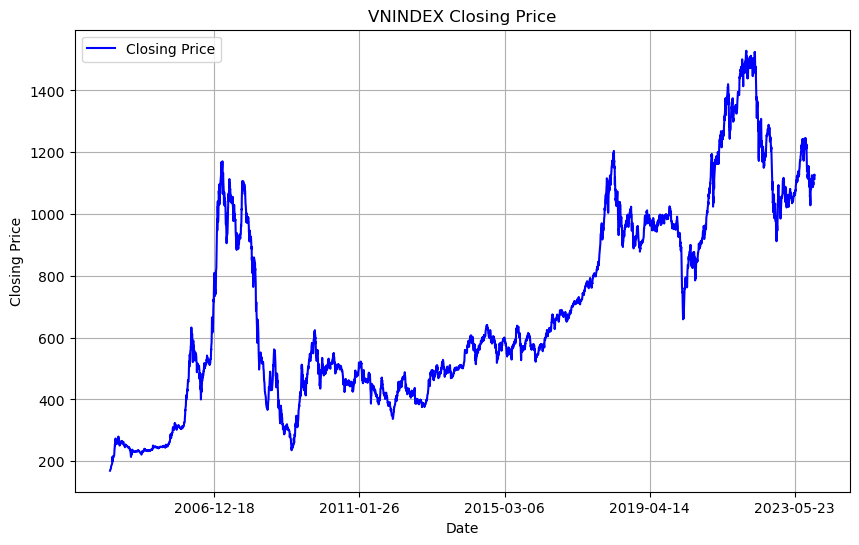

In [4]:
# Plotting the close price of the data
plt.figure(figsize=(10, 6))
plt.plot(df['TradingDate'], df['Close'], label='Closing Price', color='blue')
plt.title('VNINDEX Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=8))

plt.grid(True)
plt.show()


## 2. Calculate data

Calulate time series indicator: log return

In [5]:
df['LogReturn'] = df['Close'].pct_change().apply(lambda x: np.log(1 + x))

Calculate DC Return
threshold is set subjectively at 30%

In [6]:
threshold = 0.3
TMV_list = []
T_list = []
colors = []
events = []
trend= []
ext_point_list = []
curr_event_max_list = [] 
curr_event_min_list = []

ext_point_n = df['Close'].iloc[0]
curr_event_max = df['Close'].iloc[0]
curr_event_min = df['Close'].iloc[0]
time_point_max = 0
time_point_min = 0
trend_status = 'up'
T = 0

for i in range(len(df['Close'])):
    TMV = (abs(df['Close'].iloc[i] - ext_point_n)) / (ext_point_n * threshold)
    TMV_list.append(TMV)
    T_list.append(T)
    T += 1
    
    if trend_status == 'up':
        colors.append('lime')
        events.append('Upward Overshoot')
        trend.append(trend_status)

        if df['Close'].iloc[i] < ((1 - threshold) * curr_event_max):
            trend_status = 'down'
            curr_event_min = df['Close'].iloc[i]
            
            ext_point_n = curr_event_max
            T = i - time_point_max
            num_points_change = i - time_point_max
            
            for j in range(1, num_points_change + 1):
                colors[-j] = 'red'
                events[-j] = 'Downward DCC'
                trend[-j] = 'down'
                T_list[-j] = T+1-j
      
            
        else:
            if df['Close'].iloc[i] > curr_event_max:
                curr_event_max = df['Close'].iloc[i]
                time_point_max = i
          
    
    else:
        colors.append('lightcoral')
        events.append('Downward Overshoot')
        trend.append('down')

        if df['Close'].iloc[i] > ((1 + threshold) * curr_event_min):
            trend_status = 'up'
            curr_event_max = df['Close'].iloc[i]
            
            ext_point_n = curr_event_min
            T = i - time_point_min
            num_points_change = i - time_point_min
            for j in range(1, num_points_change + 1):
                colors[-j] = 'green'
                events[-j] = 'Upward DCC'
                trend[-j] = 'up'
                T_list[-j] = T+1-j
        else:
            if df['Close'].iloc[i] < curr_event_min:
                curr_event_min = df['Close'].iloc[i]
                time_point_min = i
                
            
                
    ext_point_list.append(ext_point_n)
    curr_event_max_list.append(curr_event_max) 
    curr_event_min_list.append(curr_event_min)
                
colors = np.array(colors)




Text(0, 0.5, 'Normalized TMV')

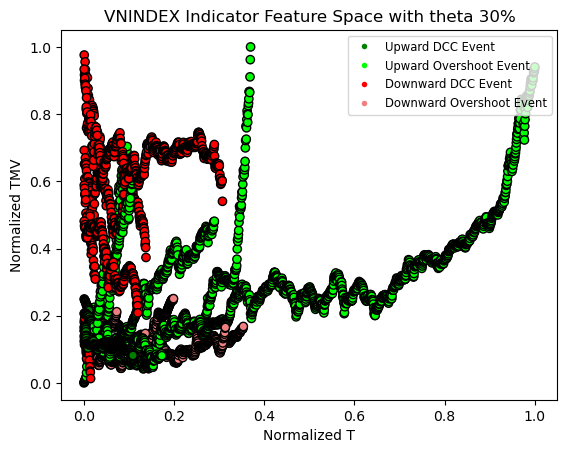

In [7]:
# Plot the indicator space
TMV_array = np.array(TMV_list)
T_array = np.array(T_list)
norm_TMV = (TMV_array - np.min(TMV_array)) / (np.max(TMV_array) - np.min(TMV_array))
norm_T = (T_array - np.min(T_array)) / (np.max(T_array) - np.min(T_array))

fig, ax = plt.subplots()
ax.scatter(norm_T, norm_TMV, c=colors, edgecolors='k')
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5,
                              label='Upward DCC Event'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=5,
                              label='Upward Overshoot Event'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5,
                              label='Downward DCC Event'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=5,
                              label='Downward Overshoot Event')]
ax.legend(handles=legend_elements, loc='upper right', fontsize='small')
#ax.set_xlim(np.min(norm_T) - 0.1, np.max(norm_T) + 0.1)
#ax.set_ylim(np.min(norm_TMV) - 0.1, np.max(norm_TMV) + 0.1)
ax.set_title('VNINDEX Indicator Feature Space with theta 30%')
ax.set_xlabel('Normalized T')
ax.set_ylabel('Normalized TMV')


Collect all data into a dataframe, including DC indicator: LogReturnDC  and time series indicator:LogReturn

In [8]:
event_df = pd.DataFrame({
    'TradingDate': df['TradingDate'],
    'colors': colors,
    'events': events,
    'TMV': TMV_array,
    'Time':T_array,
    'extreme point':ext_point_list,
    'current max':curr_event_max_list,
    'current min':curr_event_min_list,
    'trend':trend
})


df_merged = pd.merge(df, event_df, on='TradingDate')

#Calculate TMV
df_merged['LogReturnDC'] = abs(df_merged['TMV'])*threshold/df_merged['Time']

df_merged = df_merged.dropna().reset_index(drop=True)
# Display the resulting DataFrame
df_merged

,Ticker,TradingDate,Close,Highest,Lowest,Open,Total Trading Value (billion VND),Total Trading Volume (shares),LogReturn,colors,events,TMV,Time,extreme point,current max,current min,trend,LogReturnDC
0,VNINDEX,2004-01-06,170.26,170.78,170.26,170.78,3.83,"206,380",0.006482,lime,Upward Overshoot,0.021676,1,169.16,170.26,169.16,up,0.006503
1,VNINDEX,2004-01-07,171.17,171.17,170.84,170.84,2.03,"107,740",0.005331,lime,Upward Overshoot,0.039607,2,169.16,171.17,169.16,up,0.005941
2,VNINDEX,2004-01-08,171.60,171.79,171.6,171.79,3.82,"211,360",0.002509,lime,Upward Overshoot,0.048081,3,169.16,171.60,169.16,up,0.004808
3,VNINDEX,2004-01-09,173.27,173.27,171.44,171.44,2.09,"121,590",0.009685,lime,Upward Overshoot,0.080988,4,169.16,173.27,169.16,up,0.006074
4,VNINDEX,2004-01-12,174.13,174.13,173.46,173.46,2.71,"145,050",0.004951,lime,Upward Overshoot,0.097935,5,169.16,174.13,169.16,up,0.005876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4956,VNINDEX,2023-12-07,1121.49,"1,129.83","1,109.51","1,128.67","27,401.24","1,257,964,475",-0.004395,lime,Upward Overshoot,0.766129,265,911.90,1245.50,911.90,up,0.000867
4957,VNINDEX,2023-12-08,1124.44,"1,127.46","1,119.43","1,122.09","17,714.44","771,456,287",0.002627,lime,Upward Overshoot,0.776913,266,911.90,1245.50,911.90,up,0.000876
4958,VNINDEX,2023-12-11,1125.50,"1,129.15","1,120.32","1,127.92","14,630.63","652,376,929",0.000942,lime,Upward Overshoot,0.780787,267,911.90,1245.50,911.90,up,0.000877
4959,VNINDEX,2023-12-12,1127.63,"1,129.77","1,123.35","1,127.55","13,951.66","604,857,077",0.001891,lime,Upward Overshoot,0.788573,268,911.90,1245.50,911.90,up,0.000883


Plot the close price with DC Event Classification

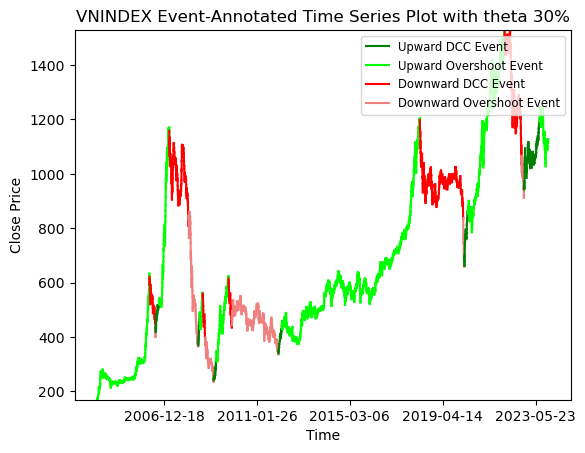

In [9]:
green_patch = plt.Line2D([0], [0], color='green', label='Upward DCC Event')
lime_patch = plt.Line2D([0], [0], color='lime', label='Upward Overshoot Event')
red_patch = plt.Line2D([0], [0], color='red', label='Downward DCC Event')
lightcoral_patch = plt.Line2D([0], [0], color='lightcoral', label='Downward Overshoot Event')

fig1, ax1 = plt.subplots()
ax1.ticklabel_format(style='plain', axis='y', useOffset=False)
for i, color in enumerate(colors):
    ax1.plot(df['TradingDate'][i: i + 2], df['Close'][i: i + 2], color=color)
   

ax1.set_ylim(df['Close'].min() * 0.9999, df['Close'].max() * 1.0001)
ax1.set_title('VNINDEX Event-Annotated Time Series Plot with theta 30%')
ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price')
ax1.legend(handles=[green_patch, lime_patch, red_patch, lightcoral_patch], loc='upper right', fontsize='small')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=8))
plt.show()

## 3. Fit Hidden Marlov Model and plot

Fit DC indicator: LogReturnDC and time series indicator:LogReturn in to Hidden Markov Model, assumming they follow Gaussian distribution

Split train data and test data according to ratio 80:20, 
which is equivalent to train data is from year 2004 to 2019, and test data is from year 2020 to 2023


In [10]:
# Filter rows for train data
start_date = '2004-01-05'
end_date = '2019-12-31'
train_data = df_merged[(df_merged['TradingDate'] >= start_date) & (df_merged['TradingDate'] <= end_date)]
train_data

,Ticker,TradingDate,Close,Highest,Lowest,Open,Total Trading Value (billion VND),Total Trading Volume (shares),LogReturn,colors,events,TMV,Time,extreme point,current max,current min,trend,LogReturnDC
0,VNINDEX,2004-01-06,170.26,170.78,170.26,170.78,3.83,"206,380",0.006482,lime,Upward Overshoot,0.021676,1,169.16,170.26,169.16,up,0.006503
1,VNINDEX,2004-01-07,171.17,171.17,170.84,170.84,2.03,"107,740",0.005331,lime,Upward Overshoot,0.039607,2,169.16,171.17,169.16,up,0.005941
2,VNINDEX,2004-01-08,171.60,171.79,171.6,171.79,3.82,"211,360",0.002509,lime,Upward Overshoot,0.048081,3,169.16,171.60,169.16,up,0.004808
3,VNINDEX,2004-01-09,173.27,173.27,171.44,171.44,2.09,"121,590",0.009685,lime,Upward Overshoot,0.080988,4,169.16,173.27,169.16,up,0.006074
4,VNINDEX,2004-01-12,174.13,174.13,173.46,173.46,2.71,"145,050",0.004951,lime,Upward Overshoot,0.097935,5,169.16,174.13,169.16,up,0.005876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3968,VNINDEX,2019-12-25,960.92,962.83,957.5,958.18,"3,663.56","235,025,084",0.002125,red,Downward DCC,6.178937,431,336.73,1204.33,336.73,down,0.004301
3969,VNINDEX,2019-12-26,958.59,962.11,957.43,960.67,"4,712.29","264,335,777",-0.002428,red,Downward DCC,6.155872,432,336.73,1204.33,336.73,down,0.004275
3970,VNINDEX,2019-12-27,963.51,963.51,954.19,957.7,"3,130.02","178,754,671",0.005119,red,Downward DCC,6.204575,433,336.73,1204.33,336.73,down,0.004299
3971,VNINDEX,2019-12-30,965.03,967.52,962.47,962.89,"2,887.06","175,590,090",0.001576,red,Downward DCC,6.219622,434,336.73,1204.33,336.73,down,0.004299


In [11]:
# Filter rows for test data
start_date = '2020-01-02'
end_date = '2023-12-13'
test_data = df_merged[(df_merged['TradingDate'] >= start_date) & (df_merged['TradingDate'] <= end_date)]
test_data

,Ticker,TradingDate,Close,Highest,Lowest,Open,Total Trading Value (billion VND),Total Trading Volume (shares),LogReturn,colors,events,TMV,Time,extreme point,current max,current min,trend,LogReturnDC
3973,VNINDEX,2020-01-02,966.67,966.67,959.67,960.26,"3,444.65","199,078,197",0.005893,red,Downward DCC,6.235857,436,336.73,1204.33,336.73,down,0.004291
3974,VNINDEX,2020-01-03,965.14,970.88,965.14,968.72,"2,702.03","163,377,030",-0.001584,red,Downward DCC,6.220711,437,336.73,1204.33,336.73,down,0.004271
3975,VNINDEX,2020-01-06,955.79,963.2,955.59,962.79,"2,963.47","174,743,568",-0.009735,red,Downward DCC,6.128154,438,336.73,1204.33,336.73,down,0.004197
3976,VNINDEX,2020-01-07,958.88,959.46,953.19,955.79,"3,235.38","170,274,833",0.003228,red,Downward DCC,6.158742,439,336.73,1204.33,336.73,down,0.004209
3977,VNINDEX,2020-01-08,948.98,955.84,945.28,954.13,"4,982.60","314,889,160",-0.010378,red,Downward DCC,6.060741,440,336.73,1204.33,336.73,down,0.004132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4956,VNINDEX,2023-12-07,1121.49,"1,129.83","1,109.51","1,128.67","27,401.24","1,257,964,475",-0.004395,lime,Upward Overshoot,0.766129,265,911.90,1245.50,911.90,up,0.000867
4957,VNINDEX,2023-12-08,1124.44,"1,127.46","1,119.43","1,122.09","17,714.44","771,456,287",0.002627,lime,Upward Overshoot,0.776913,266,911.90,1245.50,911.90,up,0.000876
4958,VNINDEX,2023-12-11,1125.50,"1,129.15","1,120.32","1,127.92","14,630.63","652,376,929",0.000942,lime,Upward Overshoot,0.780787,267,911.90,1245.50,911.90,up,0.000877
4959,VNINDEX,2023-12-12,1127.63,"1,129.77","1,123.35","1,127.55","13,951.66","604,857,077",0.001891,lime,Upward Overshoot,0.788573,268,911.90,1245.50,911.90,up,0.000883


Deal with Directional Change with LogReturnDC

In [12]:
# Set a random seed for reproducibility
np.random.seed(20)

# Extract LogReturnDC data
X = train_data['LogReturnDC'].values.reshape(-1, 1)
Y = test_data['LogReturnDC'].values.reshape(-1, 1)

# Fit Gaussian HMM model
model = GaussianHMM(n_components=2, covariance_type='full', algorithm="viterbi")
model.fit(X)

# Predict the hidden states
hidden_states = model.predict(Y)

# Add the hidden states as a new column in the DataFrame
test_data['hidden_states'] = hidden_states

# Decode the hidden states back to categorical values
test_data['hidden_states'] = np.where(test_data['hidden_states'] == 0, 'State0', 'State1')

# Print the predicted states
print("Predicted States for Test Data:", hidden_states)

Predicted States for Test Data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\user\AppData\Local\Temp\ipykernel_21392\4272348472.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['hidden_states'] = hidden_states
C:\Users\user\AppData\Local\Temp\ipykernel_21392\4272348472.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['hidden_states'] = np.where(test_data['hidden_states'] == 0, 'State0', 'State1')


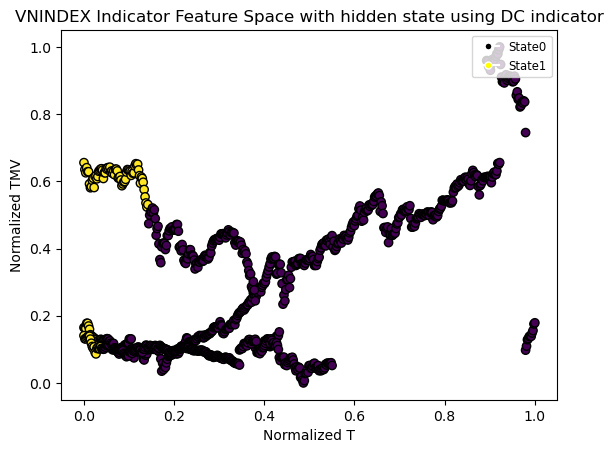

In [13]:
# Plot indicator space with hidden state
TMV_list = test_data['TMV'].tolist()
T_list = test_data['Time'].tolist()

# Use LabelEncoder to encode the 'hidden_states' column
label_encoder = LabelEncoder()
encoded_states = label_encoder.fit_transform(test_data['hidden_states'])

# Normalize the data
TMV_array = np.array(TMV_list)
T_array = np.array(T_list)
norm_TMV = (TMV_array - np.min(TMV_array)) / (np.max(TMV_array) - np.min(TMV_array))
norm_T = (T_array - np.min(T_array)) / (np.max(T_array) - np.min(T_array))

# scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(norm_T, norm_TMV, c=encoded_states, cmap='viridis', edgecolors='k')

# legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='State0'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=5, label='State1'),
]

ax.legend(handles=legend_elements, loc='upper right', fontsize='small')

# Set axis labels and title
ax.set_title('VNINDEX Indicator Feature Space with hidden state using DC indicator')
ax.set_xlabel('Normalized T')
ax.set_ylabel('Normalized TMV')

# Display the plot
plt.show()


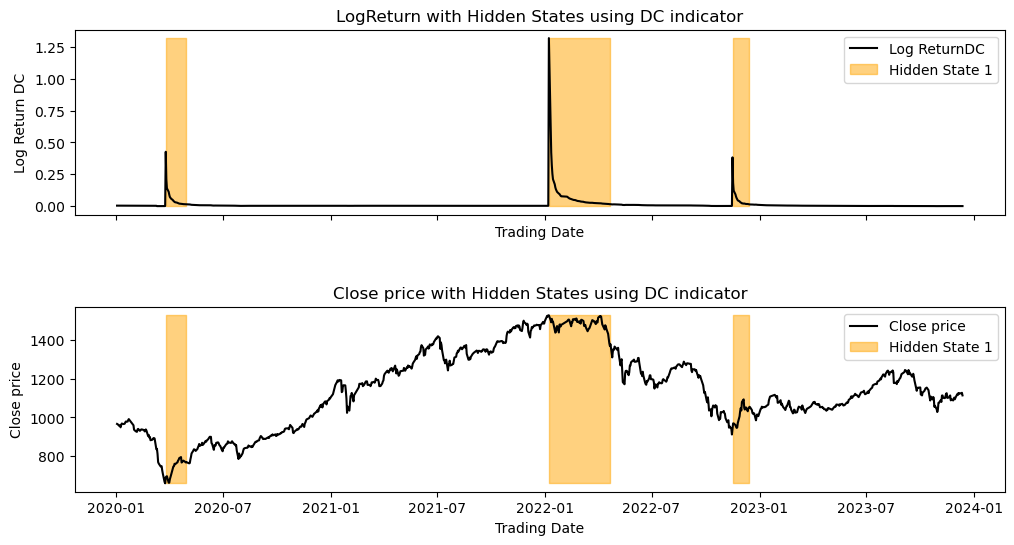

In [14]:
# Plotting graphs that use DC indicator
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12, 6))

# Plot log returns
ax1.plot(test_data['TradingDate'], test_data['LogReturnDC'], color='black', label='Log ReturnDC')
ax1.fill_between(test_data['TradingDate'], min(test_data['LogReturnDC']), max(test_data['LogReturnDC']), where=(test_data['hidden_states'] == "State1"), alpha=0.5, label='Hidden State 1', color='orange')

# Plot close price
ax2.plot(test_data['TradingDate'], test_data['Close'], color='black', label='Close price')
ax2.fill_between(test_data['TradingDate'], min(test_data['Close']), max(test_data['Close']), where=(test_data['hidden_states'] == "State1"), alpha=0.5, label='Hidden State 1', color='orange')


ax1.set_title('LogReturn with Hidden States using DC indicator')
ax1.set_xlabel('Trading Date')
ax1.set_ylabel('Log Return DC')
ax1.legend()

ax2.set_title('Close price with Hidden States using DC indicator')
ax2.set_xlabel('Trading Date')
ax2.set_ylabel('Close price')
ax2.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()


Deal with time series with LogReturn. Fit time series indicator:LogReturn in to Hidden Markov Model, assumming it follows Gaussian distribution

In [15]:
# Set a random seed for reproducibility
np.random.seed(30)


# Extract LogReturn data
X = train_data['LogReturn'].values.reshape(-1, 1)
Y = test_data['LogReturn'].values.reshape(-1, 1)

# Fit Gaussian HMM model
model = GaussianHMM(n_components=2, covariance_type='full', algorithm="viterbi")
model.fit(X)

# Predict the hidden states
hidden_states = model.predict(Y)

# Add the hidden states as a new column in the DataFrame
test_data['hidden_states'] = hidden_states

# Decode the hidden states back to categorical values
test_data['hidden_states'] = np.where(test_data['hidden_states'] == 0, 'State0', 'State1')

# Print the predicted states
print("Predicted States for Test Data:", hidden_states)

Predicted States for Test Data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\user\AppData\Local\Temp\ipykernel_21392\1093703601.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['hidden_states'] = hidden_states
C:\Users\user\AppData\Local\Temp\ipykernel_21392\1093703601.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['hidden_states'] = np.where(test_data['hidden_states'] == 0, 'State0', 'State1')


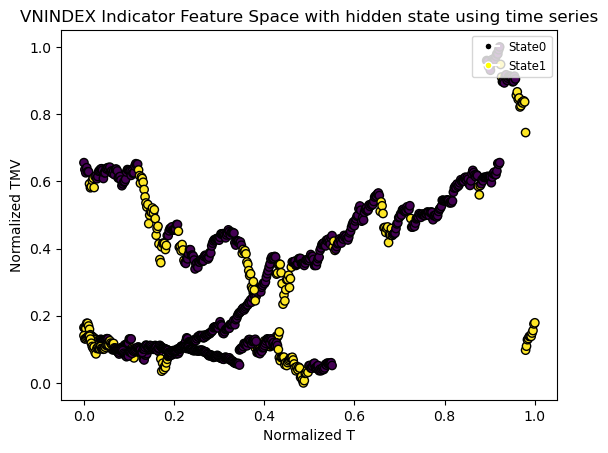

In [16]:
# Plot indicator space with hidden state
TMV_list = test_data['TMV'].tolist()
T_list = test_data['Time'].tolist()

# Use LabelEncoder to encode the 'hidden_states' column
label_encoder = LabelEncoder()
encoded_states = label_encoder.fit_transform(test_data['hidden_states'])

# Normalize the data
TMV_array = np.array(TMV_list)
T_array = np.array(T_list)
norm_TMV = (TMV_array - np.min(TMV_array)) / (np.max(TMV_array) - np.min(TMV_array))
norm_T = (T_array - np.min(T_array)) / (np.max(T_array) - np.min(T_array))

# scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(norm_T, norm_TMV, c=encoded_states, cmap='viridis', edgecolors='k')

# legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='State0'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=5, label='State1'),
]

ax.legend(handles=legend_elements, loc='upper right', fontsize='small')

# Set axis labels and title
ax.set_title('VNINDEX Indicator Feature Space with hidden state using time series')
ax.set_xlabel('Normalized T')
ax.set_ylabel('Normalized TMV')

# Display the plot
plt.show()


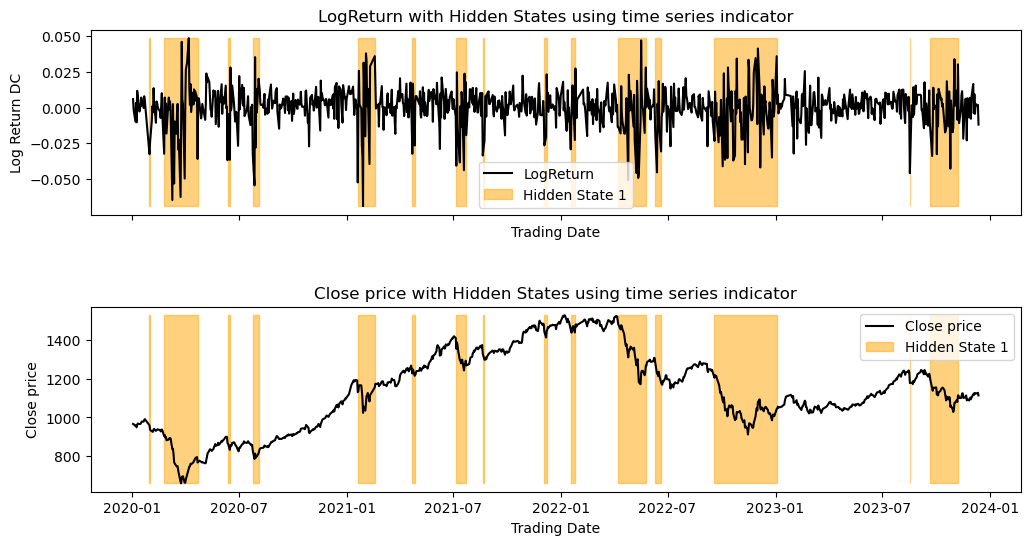

In [17]:
# Plotting graphs that use DC indicator
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12, 6))

# Plot log returns
ax1.plot(test_data['TradingDate'], test_data['LogReturn'], color='black', label='LogReturn')
ax1.fill_between(test_data['TradingDate'], min(test_data['LogReturn']), max(test_data['LogReturn']), where=(test_data['hidden_states'] == "State1"), alpha=0.5, label='Hidden State 1', color='orange')

# Plot close price
ax2.plot(test_data['TradingDate'], test_data['Close'], color='black', label='Close price')
ax2.fill_between(test_data['TradingDate'], min(test_data['Close']), max(test_data['Close']), where=(test_data['hidden_states'] == "State1"), alpha=0.5, label='Hidden State 1', color='orange')


ax1.set_title('LogReturn with Hidden States using time series indicator')
ax1.set_xlabel('Trading Date')
ax1.set_ylabel('Log Return DC')
ax1.legend()

ax2.set_title('Close price with Hidden States using time series indicator')
ax2.set_xlabel('Trading Date')
ax2.set_ylabel('Close price')
ax2.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()


Calculate components of HMM models:

In [18]:
# Extract LogReturnDC data
X = train_data['LogReturnDC'].values.reshape(-1, 1)
Y = test_data['LogReturnDC'].values.reshape(-1, 1)
model = GaussianHMM(n_components=2, covariance_type='full', algorithm="viterbi")
model.fit(X)

# Predict the hidden states
hidden_states = model.predict(Y)


# Extract model parameters
transition_matrix = model.transmat_
means = model.means_
covariances = model.covars_

print("Transition Matrix Probabilities:", transition_matrix)
print("Means:", model.means_)
print("Covars:", model.covars_)

Transition Matrix Probabilities: [[0.99684408 0.00315592]
 [0.0249412  0.9750588 ]]
Means: [[0.00325483]
 [0.10568508]]
Covars: [[[1.54338174e-05]]

 [[6.24188540e-02]]]


In [22]:
import numpy as np

def compute_initial_probability(transition_matrix):
    # Compute the left eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)

    # Find the index corresponding to the eigenvalue 1
    index = np.where(np.isclose(eigenvalues, 1))[0][0]

    # Extract the left eigenvector corresponding to eigenvalue 1
    left_eigenvector = eigenvectors[:, index].real

    # Normalize to ensure it's a valid probability distribution
    initial_probability = left_eigenvector / np.sum(left_eigenvector)

    return initial_probability

initial_probability = compute_initial_probability(transition_matrix)
print("Computed Initial Probability:", initial_probability)


Computed Initial Probability: [0.88767814 0.11232186]


In [23]:
log_likelihood_model = model.score(Y)
aic = model.aic(Y)
bic = model.bic (Y)

print(f"Log Likelihood (Model's score method): {log_likelihood_model}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

Log Likelihood (Model's score method): 3841.62660031285
AIC: -7669.2532006257
BIC: -7634.983421741465


In [24]:
# Access means and covariances
means = model.means_
covars = model.covars_
model.n_components =2

# Calculate emission probabilities for each state
emission_probabilities = np.zeros((model.n_components, len(X)))

for i in range(model.n_components):
    distribution = multivariate_normal(mean=means[i, 0], cov=covars[i, 0, 0])
    emission_probabilities[i, :] = distribution.pdf(X)

# Normalize emission probabilities
emission_probabilities /= emission_probabilities.sum(axis=0)
print("Emission Probabilities:")
print(emission_probabilities)


Emission Probabilities:
[[0.97995619 0.98198635 0.98456995 ... 0.98521963 0.98521913 0.98525622]
 [0.02004381 0.01801365 0.01543005 ... 0.01478037 0.01478087 0.01474378]]


In [25]:
import numpy as np

def forward_algorithm(obs, states, start_prob, trans_prob, emission_prob):
    T = len(obs)
    N = len(states)

    # Initialize the forward probabilities matrix
    alpha = np.zeros((T, N))

    # Initialization step
    obs_idx = int(obs[0])  # Convert to integer
    alpha[0, :] = start_prob * emission_prob[:, obs_idx]

    # Recursion step
    for t in range(1, T):
        for j in range(N):
            obs_idx = int(obs[t])  # Convert to integer
            alpha[t, j] = np.sum(alpha[t-1, :] * trans_prob[:, j]) * emission_prob[j, obs_idx]

    # Termination step
    likelihood = np.sum(alpha[-1, :])

    return alpha, likelihood

# Example usage
obs_sequence = Y  
hidden_states = [0, 1]  
initial_probs = initial_probability 
transition_probs = transition_matrix  
emission_probs = emission_probabilities 

forward_probs, sequence_likelihood = forward_algorithm(obs_sequence, hidden_states, initial_probs, transition_probs, emission_probs)

print("Forward Probabilities:")
print(forward_probs)
print("Probability of the Sequence:", sequence_likelihood)


Forward Probabilities:
[[8.69885687e-01 2.25135815e-03]
 [8.49814624e-01 9.90263985e-05]
 [8.30155328e-01 5.56918254e-05]
 ...
 [8.46215834e-11 5.59152079e-15]
 [8.26638749e-11 5.46216173e-15]
 [8.07514576e-11 5.33579538e-15]]
Probability of the Sequence: 8.075679344383764e-11
